## Load YaleB data
## Extract DSIFT features

In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd("./SSC_ADMM_v1.1")

'C:\\Users\\aleks_000\\Desktop\\Mentorship\\!GitHub'

In [ ]:
import img2matrix
import numpy as np

In [2]:
%%time
train, test, img_size = img2matrix.batch_convert_YaleB('./data/CroppedYale', truncate_num=38, images_per_person=None)

images_full = train[0]
labels = train[1]

images_raw = images_full[:, :32256]
images_dsift = images_full[:, 32256:]
print(images_raw.shape)
print(images_dsift.shape)

(2350, 32256)
(2350, 28672)


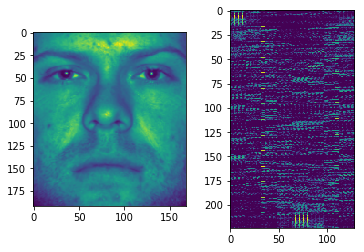

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(images_dsift[0].reshape((18, 64)))
ax[0].imshow(images_raw[0].reshape((-1, 168)));
ax[1].imshow(images_dsift[0].reshape((-1, 128)));

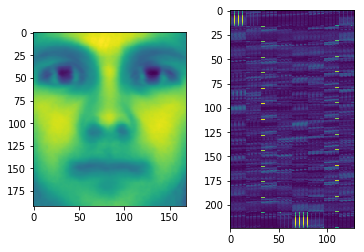

In [4]:
fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(np.mean(images_dsift, axis=0).reshape((18, 64)))
ax[0].imshow(np.mean(images_raw, axis=0).reshape((-1, 168)));
ax[1].imshow(np.mean(images_dsift, axis=0).reshape((-1, 128)));

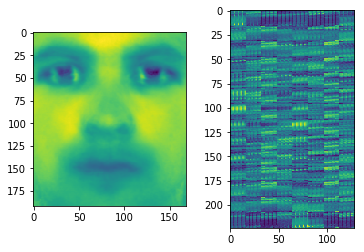

In [5]:
fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(np.std(images_dsift, axis=0).reshape((18, 64)))
ax[0].imshow(np.std(images_raw, axis=0).reshape((-1, 168)));
ax[1].imshow(np.std(images_dsift, axis=0).reshape((-1, 128)));

## Perform PCA

In [6]:
from sklearn.decomposition import PCA
import numpy as np
    
pca = PCA(n_components=300, whiten=False, svd_solver='arpack', random_state=0)
#images_pca = pca.fit_transform(np.concatenate((1*images_raw, 10*images_dsift), axis=1))
images_pca = pca.fit_transform(images_dsift)

images_pca.shape

(2350, 300)

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

def visualize(images, labels):
    tsne = TSNE()
    images_tsne = tsne.fit_transform(images)
    plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels)
    plt.show()
    
    tsne2 = TSNE(n_components=3)
    images_tsne2 = tsne2.fit_transform(images)
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(images_tsne2[:, 0], images_tsne2[:, 1], images_tsne2[:, 2], c=labels)
    
    def init():
        return (scatter,)
    def animate(angle):
        ax.view_init(30, 2*angle)
        return (scatter,)
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=180, interval=40, blit=True)
    return HTML(anim.to_html5_video())

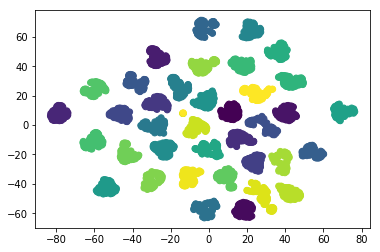

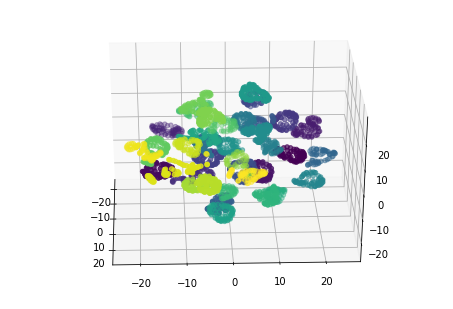

In [20]:
%%time
visualize(images_pca, labels)

In [8]:
def display_image(image, height, width):
    print(np.min(image), np.max(image))
    imgplot = plt.imshow(image.reshape((height, width)))

-2.4952768681340927 3.9265003715192783


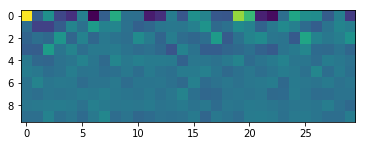

In [9]:
import matplotlib.pyplot as plt

# these are reduced parameters - not supposed to look like anything
display_image(images_pca[0], 10, 30)

-6.033471594675691e-16 4.828052851130548e-16


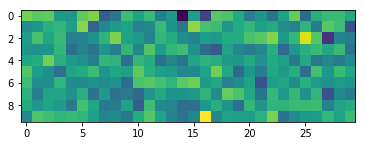

In [10]:
display_image(np.mean(images_pca, axis=0), 10, 30)

0.2566093011920059 2.6429238293260697


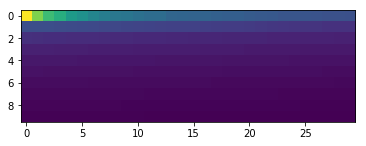

In [11]:
display_image(np.std(images_pca, axis=0), 10, 30)

## Normalize PCA output

In [12]:
# Types:
# feature-wise - normalization occurs along one pixel of all images
# image-wise - normalization occurs along all pixels of one image
# all - normalization occurs along all pixels of all images

# Methods:
# standard - mean is set to 0, std is set to 1
# [-1, 1] - min and max are used to linearly change the data range to [-1, 1]
# unit-vector - each bin is divided by its euclidean distance

#[BAD] feature, standard
#images_norm = (images_pca - np.mean(images_pca, axis=0)) / np.std(images_pca, axis=0)
# image, standard
#images_norm = (images_pca - np.mean(images_pca, axis=1)[:, np.newaxis]) / np.std(images_pca, axis=1)[:, np.newaxis]
# all, standard
#images_norm = (images_pca - np.mean(images_pca)) / np.std(images_pca)


#[BAD] feature, [-1, 1]
#mmin = np.min(images_pca, axis=0)
#mmax = np.max(images_pca, axis=0)
#[BAD] image, [-1, 1]
#mmin = np.min(images_pca, axis=1)[:, np.newaxis]
#mmax = np.max(images_pca, axis=1)[:, np.newaxis]
# all, [-1, 1]
mmin = np.min(images_pca)
mmax = np.max(images_pca)
# FOR ALL:
images_norm = (2*images_pca - mmax - mmin) / (mmax - mmin)

#[BAD] feature, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=0))
# image, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=1))[:, np.newaxis]
# all, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca))

-0.4795362210162537 0.7368686509962333


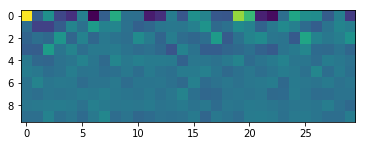

In [60]:
import matplotlib.pyplot as plt

# these are reduced parameters - not supposed to look like anything
display_image(images_norm[0], 10, 30)

-0.006884052286993181 -0.006884052286992986


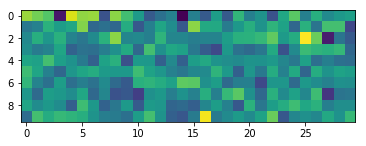

In [61]:
display_image(np.mean(images_norm, axis=0), 10, 30)

0.048606607256050476 0.5006192682142397


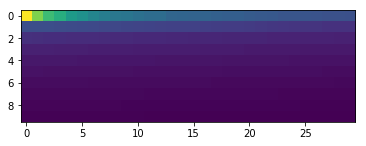

In [62]:
display_image(np.std(images_norm, axis=0), 10, 30)

## Calculate C matrix

In [63]:
import dsc
import numpy as np
import supporting_files.sda as sda

from supporting_files.helpers import optimize
from scipy.io import savemat, loadmat

In [71]:
# Matlab SSC #1
savemat('./temp.mat', mdict={'X': images_norm})
k = len(np.unique(labels))
alpha = 20.0
maxIter = 6
eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter)
C = loadmat("./temp.mat")['C']

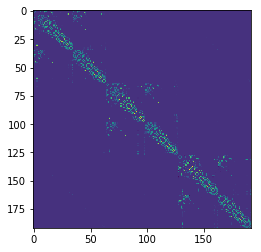

In [72]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(C[:64*3, :64*3])
plt.show()

## Train Autoencoder

In [76]:
%%time
d = dsc.DeepSubspaceClustering(images_norm, C=C, hidden_dims=[200, 150, 200], lambda1=0.0001, lambda2=0.001, learning_rate=0.006,
                               weight_init='sda-uniform', weight_init_params=[101, 0.08, images_norm.shape[0], 100],
                               optimizer='Adam', decay='sqrt', sda_optimizer='Adam', sda_decay='sqrt')

Layer 1
300 -> 200
epoch 0: global loss = 1.0675066709518433
epoch 10: global loss = 0.08655431121587753
epoch 20: global loss = 0.05894305184483528
epoch 30: global loss = 0.04430682212114334
epoch 40: global loss = 0.037475574761629105
epoch 50: global loss = 0.034731462597846985
epoch 60: global loss = 0.03334248811006546
epoch 70: global loss = 0.03261769935488701
epoch 80: global loss = 0.03219793736934662
epoch 90: global loss = 0.03193552792072296
epoch 100: global loss = 0.031763941049575806
Layer 2
200 -> 150
epoch 0: global loss = 1.3842402696609497
epoch 10: global loss = 0.20603333413600922
epoch 20: global loss = 0.07311268150806427
epoch 30: global loss = 0.057164762169122696
epoch 40: global loss = 0.04721914976835251
epoch 50: global loss = 0.040408555418252945
epoch 60: global loss = 0.03688997030258179
epoch 70: global loss = 0.035391367971897125
epoch 80: global loss = 0.03450038284063339
epoch 90: global loss = 0.03388359770178795
epoch 100: global loss = 0.03345429

In [77]:
%%time
d.train(batch_size=images_norm.shape[0], epochs=101, print_step=25)
images_HM2 = d.result
images_HM = d.reconstr

epoch 0: global loss = 0.002536993008106947
epoch 10: global loss = 0.001954094972461462
epoch 20: global loss = 0.0018300695810467005
epoch 30: global loss = 0.0017834266182035208
epoch 40: global loss = 0.0017693229019641876
epoch 50: global loss = 0.0017609507776796818
epoch 60: global loss = 0.0017555560916662216
epoch 70: global loss = 0.0017517221858724952
epoch 80: global loss = 0.0017485115677118301
epoch 90: global loss = 0.0017457492649555206
epoch 100: global loss = 0.0017433163011446595
Wall time: 4min 8s


In [ ]:
%%time
visualize(images_HM2, labels)

-0.557882 0.41285577


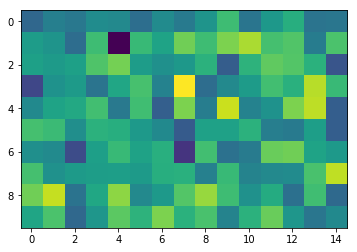

In [78]:
display_image(images_HM2[0], 10, 15)

-0.29512164 0.22539741


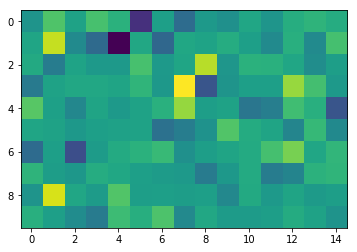

In [79]:
display_image(np.mean(images_HM2, axis=0), 10, 15)

0.113944665 0.18300796


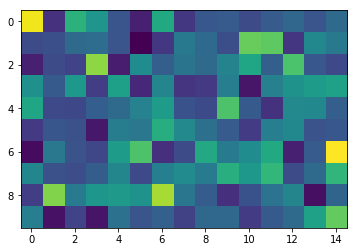

In [80]:
display_image(np.std(images_HM2, axis=0), 10, 15)

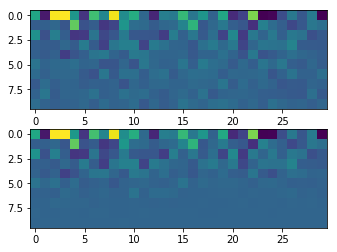

In [82]:
fig, ax = plt.subplots(2)

index = 100;
ax[0].imshow(images_norm[index].reshape((10, 30)));
ax[1].imshow(images_HM[index].reshape((10, 30)));

In [83]:
# Matlab SSC #2
savemat('./temp.mat', mdict={'X': images_HM2})
k = len(np.unique(labels))
alpha = 20.0
maxIter = 16
grps = eng.SSC_modified(k, 0, False, alpha, False, 1, 1e-20, maxIter)
labels_pred = np.asarray(grps, dtype=np.int32).flatten()

In [ ]:
%%time
visualize(images_HM2, labels_pred)

## Perform clustering with SSC

In [95]:
from supporting_files.ji_zhang import err_rate
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

print("Accuracy: ", str(1-err_rate(labels, labels_pred)))
print("NMI: ", str(nmi(labels, labels_pred)))
print("ARI: ", str(ari(labels, labels_pred)))

Accuracy:  0.997872340425532
NMI:  0.9969564614342976
ARI:  0.995533279485107
